In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
import os
os.chdir("drive/app")

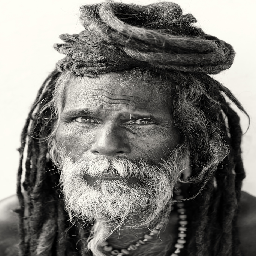

In [3]:
from PIL import Image

width = 256
height = 256

content_source = Image.open("iu-4.jpeg").resize((width, height))
content_source

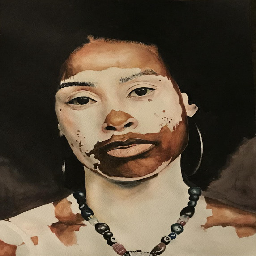

In [4]:
style_source = Image.open("bQMp_YOROUxuMdeFTW_OtWOfeo0Y6og2CIc9Vco9X0M.jpg").resize((width, height))
style_source

In [0]:
import numpy as np

content_source = np.asarray(content_source, dtype='float32')
style_source = np.asarray(style_source, dtype='float32')

In [6]:
from keras import backend as K

Using TensorFlow backend.


In [0]:
from keras.models import Model
from keras.applications.vgg16 import VGG16

In [0]:
import numpy as np

class Style_Transfer(object):
    
    def __init__(self,
                 K,
                 width,
                 height):
        
        self.K = K
        self.width = width
        self.height = height
        self.VGG_MEAN = [103.939, 116.779, 123.68]
        self.adjustments_needed = None
        self.loss_value = None
        self.gradient_values = None
            
    def to_VGG_format(self, _image):
        _image = np.expand_dims(_image, axis=0)
        _image[:,:,:,0] -= self.VGG_MEAN[0]
        _image[:,:,:,1] -= self.VGG_MEAN[1]
        _image[:,:,:,2] -= self.VGG_MEAN[2]
        _image = _image[:,:,:,::-1]
        return _image

    def from_VGG_format(self, _x):
        _x = _x.reshape( (self.width, self.height, 3) )
        _x = _x[:,:, ::-1]
        _x[:, :, 0] += self.VGG_MEAN[0]
        _x[:, :, 1] += self.VGG_MEAN[1]
        _x[:, :, 2] += self.VGG_MEAN[2]
        _x = np.clip(_x, 0, 255).astype('uint8')
        return _x

    def content_loss(self, _content, _result):
        return self.K.sum(self.K.square(_result - _content))

    def gram_matrix(self, x):
        features = self.K.batch_flatten(self.K.permute_dimensions(x, (2, 0, 1)))
        gram = self.K.dot(features, self.K.transpose(features))
        return gram

    def style_loss(self, _style, _result):
        S = self.gram_matrix(_style)
        C = self.gram_matrix(_result)
        channels = 3
        size = 256 * 256
        return self.K.sum(self.K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

    def noisy_loss(self, x):
        a = self.K.square(x[:, :self.width-1, :self.height-1, :] - x[:, 1:, :self.height-1, :])
        b = self.K.square(x[:, :self.width-1, :self.height-1, :] - x[:, :self.width-1, 1:, :])
        return self.K.sum(self.K.pow(a + b, 1.25))


    def setup_gradients_from_loss_chain(self, loss_chain, result_image):
        gradients = self.K.gradients(loss_chain, result_image)
        loss_and_gradients = [loss_chain] + gradients
        # these adjustments_needed is the derivative of the loss calculations
        self.adjustments_needed = self.K.function([result_image], loss_and_gradients)

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape( (1, self.width, self.height, 3) )
        tweaks = self.adjustments_needed([x])
        self.loss_value = tweaks[0]
        self.gradient_values = tweaks[1].flatten().astype('float64')
        return self.loss_value

    def gradients(self, x):
        assert self.loss_value is not None
        gradient_values = np.copy(self.gradient_values)
        self.loss_value = None
        self.gradient_values = None
        return gradient_values

In [0]:
helper = Style_Transfer(K, width, height)


In [0]:
content_data = helper.to_VGG_format(content_source)
style_data = helper.to_VGG_format(style_source)

In [0]:
content_image = K.variable(content_data)
style_image = K.variable(style_data)
result_image = K.placeholder((1, width, height, 3))

In [14]:
print(content_image.shape)


(1, 256, 256, 3)


In [15]:
input_tensor = K.concatenate([content_image,
                                    style_image,
                                    result_image], axis=0)

print(input_tensor.shape)

(3, 256, 256, 3)


In [0]:
CONTENT_INDEX = 0
STYLE_INDEX = 1
RESULT_INDEX = 2

In [0]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)


In [18]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 128, 128, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 64, 64, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 32, 32, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 32, 32, 512) dtype=float32>,
 'block4_co

In [0]:
loss_chain = K.variable(0.)


In [20]:
content_weight = 0.025

content_data = layers['block2_conv2'][CONTENT_INDEX,...]
result_data  = layers['block2_conv2'][RESULT_INDEX,...]
loss_chain += content_weight * helper.content_loss(content_data, result_data)

In [0]:
style_weight = 1.2

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

for layer_name in feature_layers:
    style_data = layers[layer_name][STYLE_INDEX,...]
    result_data = layers[layer_name][RESULT_INDEX,...]
    loss_chain += style_weight * helper.style_loss(style_data, result_data)


In [0]:
noisy_weight = 0.9

loss_chain += noisy_weight * helper.noisy_loss(result_image)

In [0]:
helper.setup_gradients_from_loss_chain(loss_chain, result_image)


In [0]:
from scipy.optimize import fmin_l_bfgs_b as calculus_magic
import time

In [0]:
calculated_result_data = np.random.uniform(0, 255, (1, width, height, 3)) - 128.


In [26]:
for i in range(50):
    print('Start of iteration', i)
    start_time = time.time()
    calculated_result_data, min_val, _ = calculus_magic(helper.loss, 
                                   calculated_result_data.flatten(), 
                                   fprime=helper.gradients, 
                                   maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 57102238000.0
Iteration 0 completed in 6s
Start of iteration 1
Current loss value: 30545697000.0
Iteration 1 completed in 4s
Start of iteration 2
Current loss value: 21924491000.0
Iteration 2 completed in 4s
Start of iteration 3
Current loss value: 17648278000.0
Iteration 3 completed in 4s
Start of iteration 4
Current loss value: 14164901000.0
Iteration 4 completed in 4s
Start of iteration 5
Current loss value: 12190239000.0
Iteration 5 completed in 4s
Start of iteration 6
Current loss value: 10778485000.0
Iteration 6 completed in 4s
Start of iteration 7
Current loss value: 9630896000.0
Iteration 7 completed in 4s
Start of iteration 8
Current loss value: 8913095000.0
Iteration 8 completed in 4s
Start of iteration 9
Current loss value: 8314645500.0
Iteration 9 completed in 4s
Start of iteration 10
Current loss value: 7905897500.0
Iteration 10 completed in 4s
Start of iteration 11
Current loss value: 7583346700.0
Iteration 11 completed in 4s
Start

Current loss value: 5948407300.0
Iteration 48 completed in 4s
Start of iteration 49
Current loss value: 5944134700.0
Iteration 49 completed in 4s


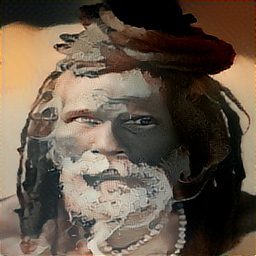

In [27]:
snapshot = helper.from_VGG_format(np.copy(calculated_result_data))
Image.fromarray(snapshot)